Recently at [work](https://monetate.com/) I have been prototyping an idea that requires numerical integration of probabilities and began to suspect I was facing issues with floating point arithmetic in certain circumstances.  To work around these issues, the standard approach is to work with on the [logarithmic scale](https://en.wikipedia.org/wiki/Log_probability) where quite small probabilities are represented by reasonably-sized negative numbers.  This post shows how [Simpsons's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) for numerical integration can be adapted to work with log scale data.  While the idea is straightforward, I made a few mistakes in the details in my first attempted implementation, so I want to record the correct approach for my future reference. 

Recall that (a basic form of) Simpson's rule works by dividing the interval of integration $[a, b]$ into many subintervals of length $h = \frac{b - a}{n}$ with endpoints $x = a + i \cdot h$ for $i = 0, \ldots, n$.  On sliding subintervials $[x_i, x_{i + 2}]$, the integrand, $f$, is approximated using a [quadratic interpolation](https://en.wikipedia.org/wiki/Polynomial_interpolation) of the points $(x_i, f(x_i))$, $(x_{i + 1}, f(x_{i + 1}))$, and $(x_{i + 2}, f(x_{i + 2}))$.  Integral over $[x_i, x_{i + 2}]$ of the resulting parabola can be evaluated exactly and used as an approximation of the integral of $f$ if $h$ is small enough.  Combining the integrals over these subintervals with appropriate weights gives the [composite Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule#Composite_Simpson's_1/3_rule),

$$
\int_a^b f(x)\ dx \approx \frac{h}{3} \left(f(x_0) + 4 \sum_{i = 1}^{\lfloor n / 2\rfloor} f(x_{2 i - 1}) + 2 \sum_{i = 1}^{\lfloor n / 2\rfloor - 1} f(x_{2 i}) + f(x_n) \right).
$$

We can rewrite the right hand side as

$$
\int_a^b f(x)\ dx \approx \sum_{i = 0}^n w_i \cdot f(x_i)
$$

where

$$
w_i = \begin{cases}
    \frac{h}{3} & i = 0 \\
    \frac{4 \cdot h}{3} & 0 < i < n \text{ is odd} \\
    \frac{2 \cdot h}{3} & 0 < i < n \text{ is even} \\
    \frac{h}{3} & i = n
\end{cases}.
$$

If we want to approximate the logarithm of the integral using values of the function $\log f$, we can rewrite the above as

$$
\begin{align}
\log \int_a^b f(x)\ dx
    & \approx \log \sum_{i = 0}^n w_i \cdot f(x_i) \\
    & = \log \sum_{i = 0}^n \exp(\log w_i + \log f(x_i)) \\
    & = \operatorname{LSE} (\log w_0 + \log f(x_0), \ldots, \log w_n + \log f(x_n)).
\end{align}
$$

Here $\text{LSE}$ is the [LogSumExp](https://en.wikipedia.org/wiki/LogSumExp) function, which is [frequently used](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations) for increasing the accuracy of log-probability calculations and is [available](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html) in SciPy.  In this case, the log weights are

$$
\log w_i = \begin{cases}
    \log h - \log 3 & i = 0 \\
    \log 4 + \log h - \log 3 & 0 < i < n \text{ is odd} \\
    \log 2 + \log h - \log 3 & 0 < i < n \text{ is even} \\
    \log h - \log 3 & i = n
\end{cases}.
$$

We now implement this log-Simpson's rule in Python.

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import logsumexp
from scipy.stats import norm
import seaborn as sns

In [3]:
sns.set(color_codes=True)

In [4]:
def log_simpson(log_y, dx, axis=-1):
    log_w = np.full(log_y.shape[axis], np.log(dx) - np.log(3.0))
    log_w[1:-1:2] += np.log(4.0)
    log_w[2:-1:2] += np.log(2.0)

    shape = [1] * len(log_y.shape)
    shape[axis] = log_y.shape[axis]
    log_w = np.reshape(log_w, shape)

    return logsumexp(log_w + log_y, axis=axis)

We validate this approximation on the log PDF ($\varphi$) and CDF ($\Phi$) of the normal distribution.  First we define an evenly spaced grid of 300 points on which to test.

In [5]:
Z_MAX = norm.isf(1e-6)

In [6]:
N = 300

In [7]:
z = np.linspace(-Z_MAX, Z_MAX, N)
dz = z[1] - z[0]

log_φz = norm.logpdf(z)

Since $\Phi(0) = \frac{1}{2}$,

$$
\log \int_{-\infty}^0 \varphi(z)\ dz = \log \Phi(0) = \log \frac{1}{2},
$$

which is

In [8]:
np.log(0.5)

-0.6931471805599453

The approximation of this quantity using our log-Simpson's rule is

In [9]:
log_simpson(np.where(z < 0, log_φz, -np.inf), dz)

-0.6889293664385137

which is not too far off the true value.  Note that here we use $-\infty$ as the log integrand for $z \geq 0$ because $\log 0 = -\infty$.

To gain further confidence in our approximation, we can approximate

$$
\log \int_{-\infty}^{z_i} \varphi(z)\ dz = \log \Phi(z_i)
$$

for each of our grid points $z_i$ for $i = 2, \ldots, n$ as follows.

In [10]:
z_grid = np.tril(np.ones((z.size, z.size)) * z)[2:]
log_φz_grid = np.where(z_grid == 0, -np.inf, norm.logpdf(z_grid))

In [11]:
cum_logΦ_approx = log_simpson(log_φz_grid, dz)

We see that, once we have accumulated a reasonable number of intervals, our approximation is reasonable.

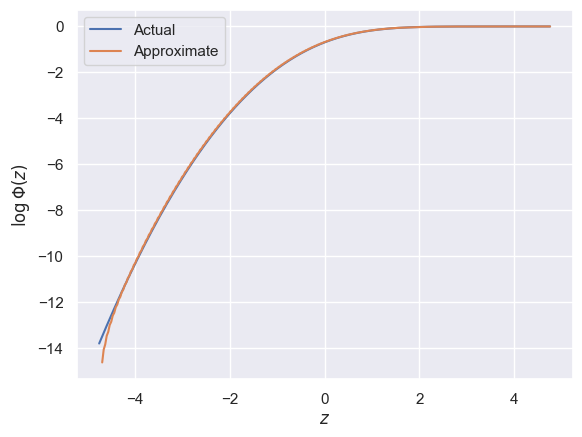

In [12]:
fig, ax = plt.subplots()

ax.plot(z, norm.logcdf(z), label="Actual");
ax.plot(z[2:], cum_logΦ_approx, label="Approximate");

ax.set_xlabel("$z$");
ax.set_ylabel(r"$\log \Phi(z)$");
ax.legend();

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/0533a976998426f9d73b69ae4bf9e51a).

In [13]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Fri Jun 06 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

scipy     : 1.14.1
seaborn   : 0.13.2
numpy     : 1.26.4
matplotlib: 3.9.2

